In [1]:
import os
import random
import re
import sys
import warnings

import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform, pdist
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from tmap.netx.SAFE import SAFE_batch, get_SAFE_summary, SAFE_single
from tmap.tda import mapper, filter
from tmap.tda.metric import Metric
from tmap.tda.plot import vis_progressX, Color
from tmap.tda.utils import optimize_dbscan_eps, cover_ratio
from tmap.tda.cover import Cover
from tmap.tda.metric import Metric

warnings.filterwarnings("ignore")


In [2]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import pandas as pd
import numpy as np
importr("vegan")

def envfit_metadata(genus_path,metadata_path):
    rcode = """
    genus_table <- read.csv('{path_data}',row.names = 1)
    metadata <- read.csv('{path_metadata}',row.names = 1)
    
    bray <- vegdist(genus_table)
    ord <- capscale(bray ~ -1)
    #plot(ord)
    """.format(path_data=genus_path,path_metadata=metadata_path)
    robjects.r(rcode)

    envfit_result = robjects.r(
    """
    fit <- envfit(ord,metadata,permutations = 999)
    fit$vectors
    """)
    fit_result = pd.DataFrame(columns=["r","pvals","Source","End"],index=robjects.r("colnames(metadata)"))
    fit_result.loc[:,"r"] = envfit_result[envfit_result.names.index("r")]
    fit_result.loc[:, "pvals"] = envfit_result[envfit_result.names.index("pvals")]
    fit_result.loc[:, ["Source","End"]] = np.array(envfit_result[envfit_result.names.index("arrows")])
    return fit_result


In [3]:

def gaussian(x, sig):
    return np.exp(-np.power(x, 2.) / (2 * np.power(sig, 2.)))

random.seed(100)
np.random.seed(100)

def get_projected_x(genus_tabs):
    tm = mapper.Mapper(verbose=0)
    dis = squareform(pdist(genus_tabs, metric="braycurtis"))
    metric = Metric(metric="precomputed")
    lens = [filter.PCOA(components=[0, 1], metric=metric, random_state=100)]
    projected_X = tm.filter(dis, lens=lens)
    projected_X = MinMaxScaler().fit_transform(projected_X)
    return projected_X

def generate_gaussian_meta_3centers(projected_X,params=(15,85)):
    center_coord_25 = np.apply_along_axis(lambda x:np.percentile(x,params[0]),0,projected_X)
    center_coord_75 = np.apply_along_axis(lambda x:np.percentile(x,params[1]),0,projected_X)

    center_points = [center_coord_25,
                np.array([center_coord_25[0],center_coord_75[1]]),
                np.array([center_coord_75[0], center_coord_25[1]])]
    ############################################################
    center_points[1][0] = (center_points[0][0] + center_points[2][0])/2
    ############################################################
    #print(center_points)
    # range_r = [0.6,0.6,0.6]
    dis_percentile = []
    for centroid in center_points:
        dis_percentile.append([((p[0]-centroid[0])**2 + (p[1]-centroid[1])**2)**0.5 for p in projected_X])
    dis_percentile = np.array(dis_percentile).T
    gaussian_v = np.apply_along_axis(lambda x:gaussian(x=x, sig=0.05),1,dis_percentile)
    generate_meta = []
    return gaussian_v.mean(1)

def select_center(projected_X,num=3,params=(15,85)):
    center_coord_25 = np.apply_along_axis(lambda x:np.percentile(x,params[0]),0,projected_X)
    center_coord_75 = np.apply_along_axis(lambda x:np.percentile(x,params[1]),0,projected_X)

    centers_ = [center_coord_25,
                center_coord_75,
                np.array([center_coord_25[0],center_coord_75[1]]),
                np.array([center_coord_75[0], center_coord_25[1]])]
    return random.sample(centers_,k=num)
def generate_meta(projected_X,dis_params=None):
    if dis_params is None:
        dis_params = dict(num=3,
                          params=(15,85))
    center_points = select_center(projected_X,num=dis_params['num'],params=dis_params['params'])

    dis_percentile = []
    for centroid in center_points:
        dis_percentile.append([((p[0]-centroid[0])**2 + (p[1]-centroid[1])**2)**0.5 for p in projected_X])
    dis_percentile = np.array(dis_percentile).T
    gaussian_v = np.apply_along_axis(lambda x:gaussian(x=x, sig=0.05),1,dis_percentile)
    return gaussian_v.mean(1)

def generate_metadata_continuous(projected_X):
    p1, p2 = [random.uniform(-1, 1) for i in [1, 2]]
    metadata = p1*projected_X[:,0]+p2*projected_X[:,1]

    return metadata

In [4]:
def get_true_pred(graph,metadata,n_iter,threshold,raw=False):
    safe_scores = SAFE_batch(graph, meta_data=metadata, n_iter=n_iter, verbose=0)
    safe_summary = get_SAFE_summary(graph,metadata,safe_scores,n_iter,threshold)
    y_true = [1 if not _.endswith('fake') else 0 for _ in metadata.columns]
    y_pred = [1 if _!=0 else 0 for _ in safe_summary.loc[metadata.columns,'SAFE enriched score']]
    if raw:
        y_true = [1 if not _.endswith('fake') else 0 for _ in metadata.columns]
        y_pred = safe_summary.loc[metadata.columns,'SAFE enriched score']
    return y_true,y_pred

In [5]:
otu_path = 'demo_mat.csv'
metadata_path = "metadata/metadata_mixed.csv"
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector
stats = importr('stats')

In [6]:
simulated_otu = pd.read_csv(otu_path, sep=',', index_col=0)
simulated_otu = simulated_otu.divide(simulated_otu.sum(1), axis=0)
dis = squareform(pdist(simulated_otu, metric="braycurtis"))

# generate graph
tm = mapper.Mapper(verbose=1)
metric = Metric(metric="precomputed")
lens = [filter.PCOA(components=[0, 1], metric=metric, random_state=100)]
projected_X = tm.filter(dis, lens=lens)
eps = optimize_dbscan_eps(simulated_otu, threshold=95)
clusterer = DBSCAN(eps=eps, min_samples=3)
r = 30
cover = Cover(projected_data=MinMaxScaler().fit_transform(projected_X), resolution=r, overlap=0.85)
graph = tm.map(data=simulated_otu, cover=cover, clusterer=clusterer)

Filtering by PCOA.
...calculate distance matrix using the precomputed metric.
Finish filtering of points cloud data.


 45%|████▌     | 406/900 [00:00<00:00, 4023.39it/s]

Mapping on data (500, 300) using lens (500, 2)
...minimal number of points in hypercube to do clustering: 3


100%|██████████| 900/900 [00:00<00:00, 3874.71it/s]


...create 217 nodes.
...calculate projection coordinates of nodes.
...construct a TDA graph.
...create 1465 edges.
Finish TDA mapping


In [7]:
# mixed scenario
num_metadata = 50
def mixed(raw=False):
    projected_X = get_projected_x(simulated_otu)
    #part 1
    metadata_1 = [generate_gaussian_meta_3centers(projected_X) for i in range(0,num_metadata)]
    metadata_1 = pd.DataFrame(metadata_1).T
    metadata_1.columns = ['meta' + str(_) for _ in range(1, num_metadata + 1)]
    #part 2
    metadata_2 = [generate_meta(projected_X, dict(num=3,params=(25, 75))) for i in range(0,num_metadata)]
    metadata_2 = pd.DataFrame(metadata_2).T
    metadata_2.columns = ['meta' + str(_) for _ in range(num_metadata+1, num_metadata*2 + 1)]
    #part 3
    metadata_3 = [generate_meta(projected_X, dict(num=2,params=(25, 75))) for i in range(0,num_metadata)]
    metadata_3 = pd.DataFrame(metadata_3).T
    metadata_3.columns = ['meta' + str(_) for _ in range(num_metadata*2+1, num_metadata*3 + 1)]
    #part 4
    metadata_4 = [generate_metadata_continuous(projected_X) for i in range(0,num_metadata)]
    metadata_4 = pd.DataFrame(metadata_4).T
    metadata_4.columns = ['meta' + str(_) for _ in range(num_metadata*3+1, num_metadata*4 + 1)]
    metadata = pd.concat([metadata_1,metadata_2,metadata_3,metadata_4],axis=1)
    
    
    li_shuffled = metadata.copy().apply(lambda x: np.random.permutation(x),axis=0)
    li_shuffled.columns = [_ + '_fake' for _ in li_shuffled.columns]
    new_metadata = pd.concat([metadata, li_shuffled], axis=1)

    new_metadata.to_csv(metadata_path, index=True)
    y_true,y_pred = get_true_pred(graph,new_metadata,n_iter=1000,threshold=0.01,raw=raw)
    
    fit_result = envfit_metadata(otu_path, metadata_path)
    p_adjust = stats.p_adjust(FloatVector(fit_result.pvals.values), method = 'BH')
    fit_result["BH_corrected"] = p_adjust
    fit_y_true = y_true[::]
    if raw:
        fit_y_pred = list(fit_result.loc[new_metadata.columns,"pvals"])
    else:
        fit_y_pred = [1 if fit_result.loc[_,'BH_corrected']<=0.05 else 0 for _ in new_metadata.columns]
    return y_true,y_pred,fit_y_pred

In [8]:
# basic rule
fsafe_recall = lambda x: recall_score(x[0],[1 if _ !=0 else 0 for _ in x[1]])
fsafe_precision = lambda x: precision_score(x[0],[1 if _!=0 else 0 for _ in x[1]])
fsafe_TNR = lambda x: precision_score(x[0],[1 if _!=0 else 0 for _ in x[1]],pos_label=0)
fenvfit_recall = lambda x: recall_score(x[0],[1 if _<=0.05 else 0 for _ in x[2]])
fenvfit_precision = lambda x: precision_score(x[0],[1 if _<=0.05 else 0 for _ in x[2]])
fenvfit_TNR = lambda x: precision_score(x[0],[1 if _<=0.05 else 0 for _ in x[2]],pos_label=0)
fsafe_f1 = lambda x: f1_score(x[0],[1 if _ !=0 else 0 for _ in x[1]])
fenvfit_f1 = lambda x: f1_score(x[0],[1 if _<=0.05 else 0 for _ in x[2]])

In [9]:
from tqdm import trange

res = []
for i in trange(0,100):
    y_true,y_pred,fit_y_pred = mixed(raw=True)
    res.append((y_true,y_pred,fit_y_pred))

100%|██████████| 100/100 [3:58:36<00:00, 143.16s/it]


In [10]:
# output raw y_true and y_pred
tmp = []
for idx,_ in enumerate(res):
    cache = pd.DataFrame(np.array(_).T,columns=['y_true_%s' % idx,
                                                'y_pred_%s' % idx,
                                                'y_envfit_%s' % idx])
    tmp.append(cache)
raw_result = pd.concat(tmp,axis=1)
raw_result.to_csv('plot_data/mix_400_raw.csv')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



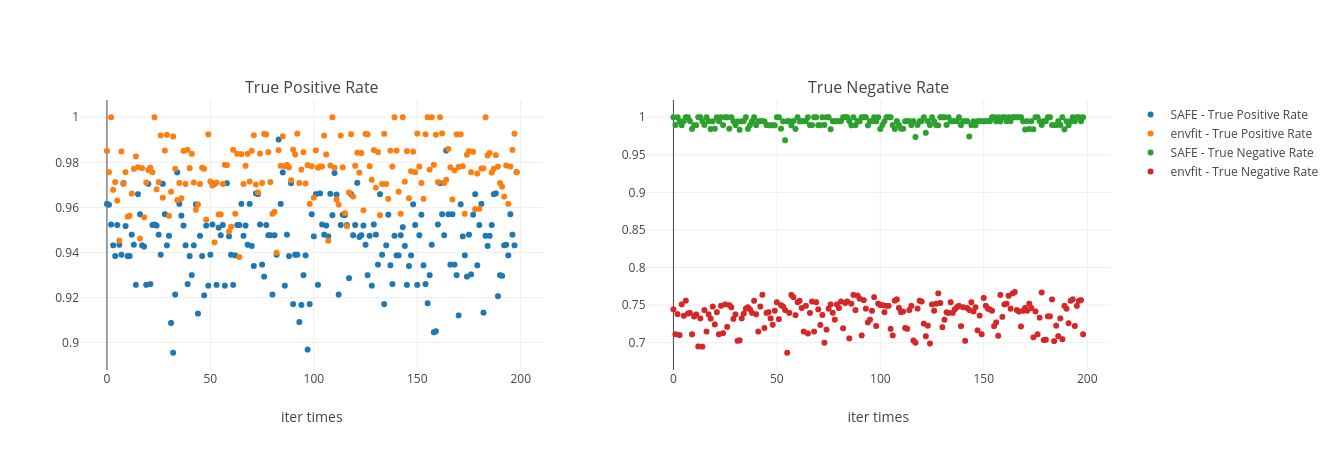

In [11]:
import plotly
import plotly.graph_objs as go
from plotly import tools


trace0 = go.Scatter(
    x = np.array(range(0,201)),
    y = list(map(fsafe_precision,res)),
    mode = 'markers',
    name = 'SAFE - True Positive Rate'
)

trace1 = go.Scatter(
    x = np.array(range(0,201)),
    y = list(map(fenvfit_precision,res)),
    mode = 'markers',
    name = "envfit - True Positive Rate"
)

trace2 = go.Scatter(
    x = np.array(range(0,201)),
    y = list(map(fsafe_TNR,res)),
    mode = 'markers',
    name = 'SAFE - True Negative Rate'
)

trace3 = go.Scatter(
    x = np.array(range(0,201)),
    y = list(map(fenvfit_TNR,res)),
    mode = 'markers',
    name = "envfit - True Negative Rate"
)
data = [trace0,trace1]

fig = tools.make_subplots(rows=1, cols=2,subplot_titles=('True Positive Rate','True Negative Rate'))
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)
fig['layout']['xaxis1'].update(title='iter times')
fig['layout']['xaxis2'].update(title='iter times')
plotly.offline.iplot(fig)
# plotly.offline.plot(fig,filename="TPR vs TNR.html",auto_open=False)



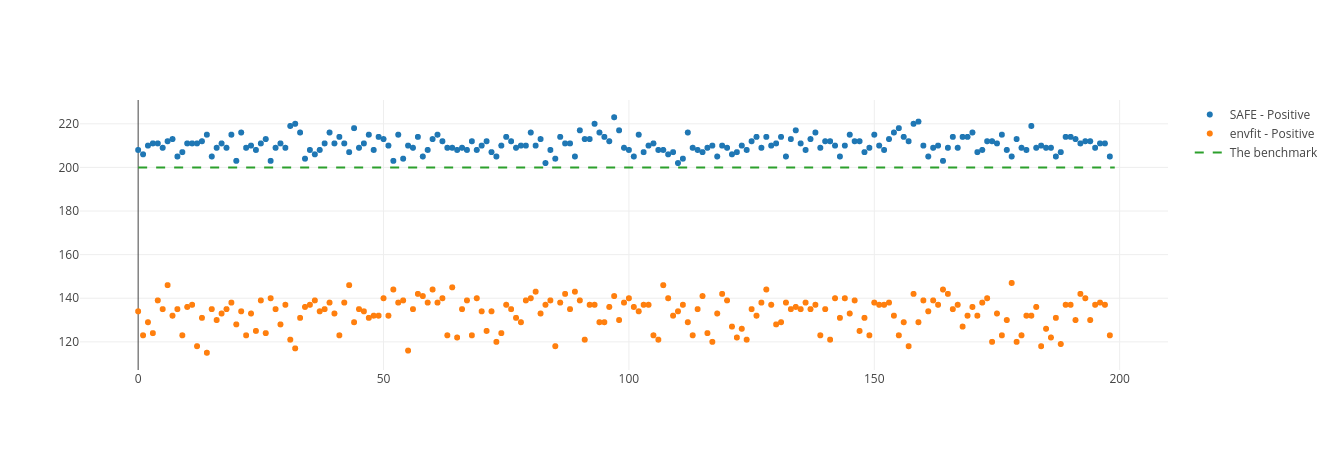

In [12]:
from collections import Counter
num_i = len(res)
trace0 = go.Scatter(
    x = np.arange(0,num_i+1),
    y = [Counter([1 if _!=0 else 0 for _ in n_iter[1]]).get(1,0) for n_iter in res],
    mode = 'markers',
    name = 'SAFE - Positive'
)

trace1 = go.Scatter(
    x = np.arange(0,num_i+1),
    y = [Counter([1 if _<=0.05 else 0 for _ in n_iter[2]]).get(1,0) for n_iter in res],
    mode = 'markers',
    name = "envfit - Positive"
)
trace2 = go.Scatter(
    x = np.arange(0,num_i+1),
    y = [num_i+1]*(num_i+1),
    line = dict(dash = 'dash'),
    name = "The benchmark"
)

data = [trace0,trace1,trace2]
layout = dict(yaxis=dict(title='number of feature'),
              xaxis=dict(title='iter times'),
              #title="Comparision of Pos"
                        font=dict(size=18))

plotly.offline.iplot(data)

# plotly.offline.plot(dict(data=data,layout = layout),filename = "comparision of postivie numbers.html",auto_open=False)


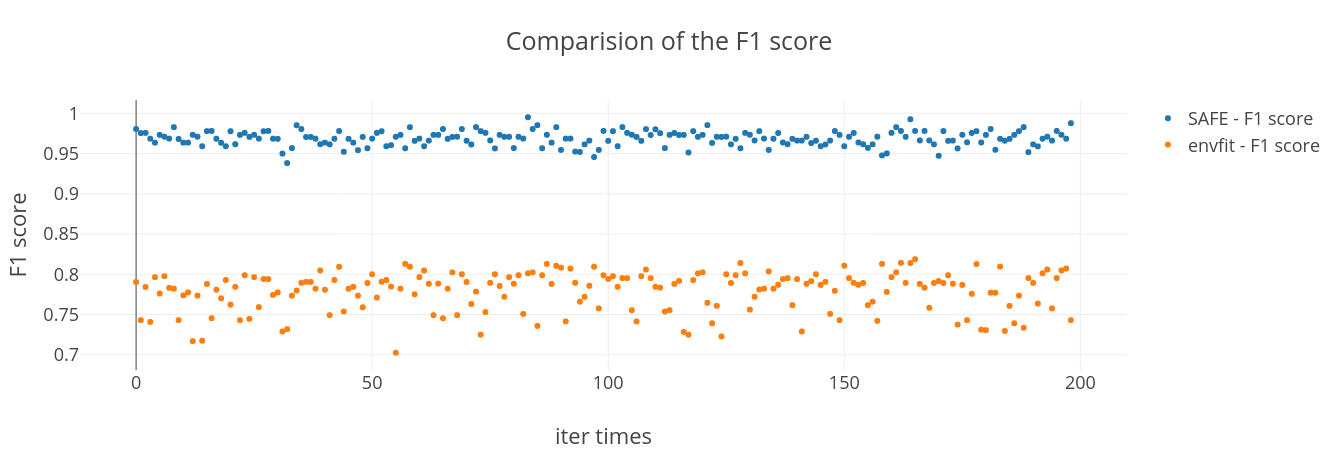

In [13]:
trace0 = go.Scatter(
    x = np.array(range(0,num_i+1)),
    y = list(map(fsafe_f1,res)),
    mode = 'markers',
    name = 'SAFE - F1 score'
)

trace1 = go.Scatter(
    x = np.array(range(0,num_i+1)),
    y = list(map(fenvfit_f1,res)),
    mode = 'markers',
    name = "envfit - F1 score"
)

data = [trace0,trace1]
layout = dict(yaxis=dict(title='F1 score'),
              xaxis=dict(title='iter times'),
              title="Comparision of the F1 score",
                        font=dict(size=18))

plotly.offline.iplot(dict(data = data,layout=layout))

# plotly.offline.plot(dict(data=data,layout = layout),filename = "comparision of F1 score.html",auto_open=False)


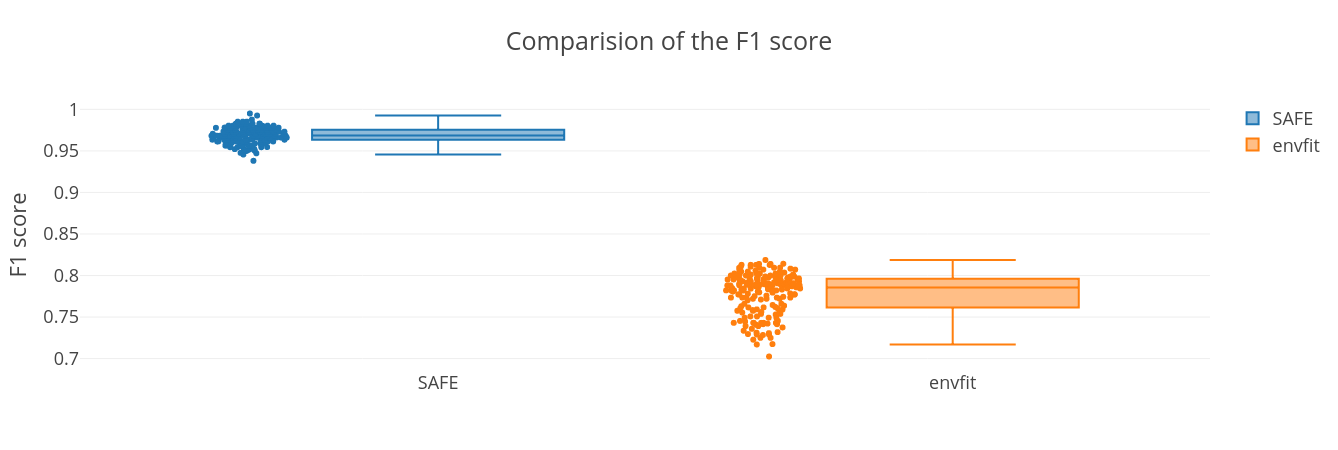

In [14]:
trace0 = go.Box(y = list(map(fsafe_f1,res)),
                text = "SAFE",
                name = "SAFE",
                #marker = dict(color=color_codes[cat]),
                boxpoints='all')

trace1 = go.Box(y = list(map(fenvfit_f1,res)),
                text = "envfit",
                name = "envfit",
                #marker = dict(color=color_codes[cat]),
                boxpoints='all')

layout = dict(yaxis=dict(title='F1 score'),
              title="Comparision of the F1 score",
                        font=dict(size=18))

data = [trace0,trace1]

plotly.offline.iplot(dict(data=data,layout=layout))
# plotly.offline.plot(dict(data=data,layout = layout),filename = "comparision of F1 score box mixed.html",auto_open=False)